Let us consider the Ornstein-Uhlenbeck process $\mathrm dx_t=-ax_t\mathrm dt+b\mathrm dW_t$. $x_t\sim\mathcal N\left(x_0e^{-at},\frac{b^2(1-e^{-2at})}{2a}\right)$ and the stationary distribution is $\mathcal N\left(0,\frac{b^2}{2a}\right)$.
If the variance is $\sigma^2$, $a=\frac{b^2}{2\sigma^2}$.


First, we import some necessary libraries

In [2]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

To use any of the estimators in the `SATRAM` package, we need to import the `ThermodynamicEstimator` of which the implementation will depend on the input parameters.

In [3]:
from satram import ThermodynamicEstimator

We set some constants. In this toy example, we have 4 thermodynamic states which are defined by added constant bias potentials `s`. We will sample `T` data points in each state. `mu` and `sigma2` define the distribution of the OU-process. `centers` are the centers of the Markov states in which we will bin our samples.

In [4]:
n_therm_states = 4 # 4 thermodynamic states
n_markov_states = 5 # 5 bins/Markov states

s = np.array([0, 0.5, 1, 2])
centers = np.linspace(-1, 1, n_markov_states).reshape(-1, 1) # Markov state bin centers

mu = np.linspace(-1, 1, n_therm_states) 
sigma2 = 0.05
T = int(1e5) # trajectory length

The method `OU_simulation` generates a trajectory. 

In [5]:
# perform simulation
def OU_simulation(mu, sigma2, b, delta_t):
    a = b * b / 2 / sigma2
    x = np.random.randn() * math.sqrt(sigma2)
    traj = np.empty([T, 1])
    r = math.exp(-a * delta_t)
    v = math.sqrt(b * b * (1 - math.exp(-2 * a * delta_t)) / 2 / a)
    for t in range(T):
        x = x * r + v * np.random.randn()
        traj[t] = x
    traj += mu
    return traj

Now we generate a trajectory for each thermodynamic state. 

In [6]:
trajs = []
for i in range(n_therm_states):
    trajs.append(OU_simulation(mu[i], sigma2, 1, 10))

Now we need to turn our trajectories into input for (SA)TRAM. We need ttrajs, dtrajs and a list of bias matrices.

* `dtrajs`: The discrete trajectories in the form of a list or array of numpy arrays. `dtrajs[i]` contains one trajectory. `dtrajs[i][n]` equals the Markov state index that the $n$-th sample from the $i$-th trajectory was binned into. Each of the `dtrajs` thus has the same length as the corresponding `traj`.


* `bias_list`: The bias energy matrices. `bias_matrices[i][n, k]` equals the bias energy of the $n$-th sample from the $i$-th trajectory, evaluated at thermodynamic state $k$, $b^k(x_{i,n})$. The bias energy matrices should have the same size as dtrajs in both the first and second dimensions. The third dimension is of size `n_therm_states`, i.e. for each sample, the bias energy in every thermodynamic state is calculated and stored in the bias_matrices.


* `ttrajs`: `ttrajs[i]` indicates for each sample in the $i$-th trajectory what thermodynamic state that sample was sampled at.

In [7]:
ttrajs = []
dtrajs = []
bias_list = []

for i, traj in enumerate(trajs):
    # no replica exchange, so ttrajs is simply the trajectory index for
    # each sample
    ttrajs.append(np.asarray([i] * T))

    # discretize trajs to create dtrajs 
    tmp_d = scipy.spatial.distance.cdist(traj, centers) ** 2
    dtraj = np.argmin(tmp_d, 1)
    dtrajs.append(dtraj)

    # create bias matrices. 
    bias = (traj - mu) ** 2 / (2 * sigma2) + s
    bias_list.append(bias)

We define a callback to keep track of the free energy estimate

In [8]:
fs = []
def callback(f, log_v):
    fs.append(f)

We use tqdm to keep track of our iterations

In [9]:
from tqdm.notebook import tqdm
progress = tqdm

Now we can use the `SATRAM` estimator to estimate the free energies. By setting `batch_size_increase=4`, the batch sizes is doubled every four epochs. The learning rate is adapted accordingly to $\eta=\sqrt{|B|/N}$.

In [10]:
max_iter = 50

estimator = ThermodynamicEstimator(progress=progress, maxiter=max_iter, device='cuda')
estimator.fit((ttrajs, dtrajs, bias_list), solver_type="SATRAM", callback=callback, batch_size_increase=4)

  0%|          | 0/50 [00:00<?, ?it/s]

increasing batch size to 512, lr to 0.03577708763999664
increasing batch size to 1024, lr to 0.05059644256269407
increasing batch size to 2048, lr to 0.07155417527999328
increasing batch size to 4096, lr to 0.10119288512538814
increasing batch size to 8192, lr to 0.14310835055998655
increasing batch size to 16384, lr to 0.20238577025077628
increasing batch size to 32768, lr to 0.2862167011199731
increasing batch size to 65536, lr to 0.40477154050155256
increasing batch size to 131072, lr to 0.5724334022399462
increasing batch size to 262144, lr to 0.8095430810031051
increasing batch size to 400000, lr to 1


We can plot the free energies of the thermodynamic states and the ground truths, `s`, to look at the convergence behaviour of the estimate.

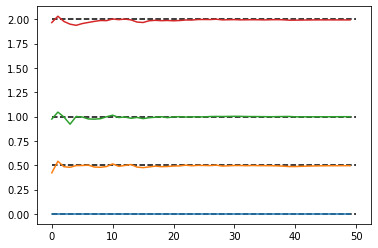

In [11]:
f_therms = -torch.logsumexp(-torch.stack(fs), 2)
f_therms -= f_therms.min(1)[0][:,None]

for i, s_i in enumerate(s):
    plt.plot([0,max_iter], [s_i, s_i], '--k')
    plt.plot(f_therms[:,i])